In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 13.5 MB/s 
     |████████████████████████████████| 182 kB 57.9 MB/s 
     |████████████████████████████████| 7.6 MB 14.1 MB/s 


In [ ]:
# For Weights and Biases
!pip install -qq wandb

     |████████████████████████████████| 1.9 MB 23.8 MB/s 
     |████████████████████████████████| 168 kB 76.0 MB/s 
     |████████████████████████████████| 182 kB 71.9 MB/s 
     |████████████████████████████████| 62 kB 1.6 MB/s 
     |████████████████████████████████| 168 kB 80.3 MB/s 
     |████████████████████████████████| 166 kB 81.8 MB/s 
     |████████████████████████████████| 166 kB 78.4 MB/s 
     |████████████████████████████████| 162 kB 81.9 MB/s 
     |████████████████████████████████| 162 kB 64.0 MB/s 
     |████████████████████████████████| 158 kB 83.7 MB/s 
     |████████████████████████████████| 157 kB 81.7 MB/s 
     |████████████████████████████████| 157 kB 86.4 MB/s 
     |████████████████████████████████| 157 kB 80.2 MB/s 
     |████████████████████████████████| 157 kB 87.5 MB/s 
     |████████████████████████████████| 157 kB 84.3 MB/s 
     |████████████████████████████████| 157 kB 86.4 MB/s 
     |████████████████████████████████| 157 kB 78.3 MB/s 
     |██████████

In [ ]:
import wandb
print("W&B: ", wandb.__version__)
from wandb.keras import WandbCallback

W&B:  0.13.5


In [ ]:
import wandb
from wandb.keras import WandbCallback
# wandb.init(project="hyperparam-test", entity="ariq913")
wandb.init(project="bert-uncased", entity="ariq913")

In [ ]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-ba51f5d9-8168-2b32-c127-4f2f3d7c4707)


In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()


'/device:GPU:0'

![](img/prepare_dataset_bert.png)

In [ ]:
max_seq_length = 22

In [ ]:
model_id="bert-base-uncased"

In [ ]:
import pandas as pd
df=pd.read_csv("/content/drive/MyDrive/cleaned_twitter_sentiment_data.csv")

In [ ]:
df.head()

,Unnamed: 0,sentiment,message,tweetid
0,0,Anti,climate change is an interesting hustle as it ...,792927353886371840
1,1,Pro,rt watch right here as travels the world to ta...,793124211518832641
2,2,Pro,fabulous leonardo s film on change is brillian...,793124402388832256
3,3,Pro,rt just watched this amazing documentary by le...,793124635873275904
4,4,News,rt pranita biswasi a lutheran from odisha give...,793125156185137153


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43943 entries, 0 to 43942
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  43943 non-null  int64 
 1   sentiment   43943 non-null  object
 2   message     43881 non-null  object
 3   tweetid     43943 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.3+ MB


In [ ]:
df["length"]=df["message"].apply(lambda x: len(str(x).split(" ")))

In [ ]:
df.describe()

,Unnamed: 0,tweetid,length
count,43943.000000,4.394300e+04,43943.000000
mean,21971.000000,8.367966e+17,16.629816
std,12685.395776,8.568506e+16,4.966776
min,0.000000,5.926334e+17,1.000000
25%,10985.500000,7.970376e+17,13.000000
50%,21971.000000,8.402301e+17,17.000000
75%,32956.500000,9.020003e+17,21.000000
max,43942.000000,9.667024e+17,34.000000


In [ ]:
min(df["length"])

1

In [ ]:
df = df.drop(df[df.length<5].index)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43559 entries, 0 to 43942
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  43559 non-null  int64 
 1   sentiment   43559 non-null  object
 2   message     43559 non-null  object
 3   tweetid     43559 non-null  int64 
 4   length      43559 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 2.0+ MB


In [ ]:
s=set(df["sentiment"])
print(s)

{'Pro', 'News', 'Neutral', 'Anti'}


In [ ]:
ch_to_int={'Anti':-1, 'News':1, 'Pro':2, 'Neutral':0}

In [ ]:
df["sentiment"]=df["sentiment"].apply(lambda x: ch_to_int[x])

In [ ]:
df.head()

,Unnamed: 0,sentiment,message,tweetid,length
0,0,-1,climate change is an interesting hustle as it ...,792927353886371840,22
1,1,2,rt watch right here as travels the world to ta...,793124211518832641,13
2,2,2,fabulous leonardo s film on change is brillian...,793124402388832256,12
3,3,2,rt just watched this amazing documentary by le...,793124635873275904,16
4,4,1,rt pranita biswasi a lutheran from odisha give...,793125156185137153,20


# Convert Raw Text to BERT Features using Hugging Face and TensorFlow

In [ ]:
import tensorflow as tf
import collections
import json
import os
import pandas as pd
import csv
# from transformers import DistilBertTokenizer

# tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# from transformers import RobertaTokenizer
# tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
from transformers  import BertTokenizer, TFBertForSequenceClassification
tokenizer = BertTokenizer.from_pretrained(model_id)


MESSAGE_COLUMN = "message"
TWEETID_COLUMN = "tweetid"

LABEL_COLUMN = "sentiment"
LABEL_VALUES = [0,1,2,-1]

label_map = {-1:0,0:1,1:2,2:3}
# for (i, label) in enumerate(LABEL_VALUES):
#     label_map[label] = i


class InputFeatures(object):
    """BERT feature vectors."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id, tweet_id, date, label):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id
        self.tweet_id = tweet_id
        self.date = date
        self.label = label


class Input(object):
    """A single training/test input for sequence classification."""

    def __init__(self, text, tweet_id, date, label=None):
        """Constructs an Input.
        Args:
          text: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
          label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.text = text
        self.tweet_id = tweet_id
        self.date = date
        self.label = label


def convert_input(the_input, max_seq_length):
    tokens = tokenizer.tokenize(the_input.text)
    tokens.insert(0, '[CLS]')
    tokens.append('[SEP]')
    # print("**{} tokens**\n{}\n".format(len(tokens), tokens))

    encode_plus_tokens = tokenizer.encode_plus(
        the_input.text,
        padding='max_length', 
        max_length=max_seq_length,
        truncation=True
    )
    
    # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
    input_ids = encode_plus_tokens["input_ids"]

    # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.
    input_mask = encode_plus_tokens["attention_mask"]

    # Segment ids are always 0 for single-sequence tasks such as text classification.  1 is used for two-sequence tasks such as question/answer and next sentence prediction.
    segment_ids = [0] * max_seq_length

    # Label for each training row (`star_rating` 1 through 5)
    label_id = label_map[the_input.label]
    # print("Here ",the_input.tweet_id)
    features = InputFeatures(
        input_ids=input_ids,
        input_mask=input_mask,
        segment_ids=segment_ids,
        label_id=label_id,
        tweet_id=the_input.tweet_id,
        date=the_input.date,
        label=the_input.label,
    )

    # print("**{} input_ids**\n{}\n".format(len(features.input_ids), features.input_ids))
    # print("**{} input_mask**\n{}\n".format(len(features.input_mask), features.input_mask))
    # print("**{} segment_ids**\n{}\n".format(len(features.segment_ids), features.segment_ids))
    # print("**label_id**\n{}\n".format(features.label_id))
    # print("**tweet_id**\n{}\n".format(features.tweet_id))
    # print("**date**\n{}\n".format(features.date))
    # print("**label**\n{}\n".format(features.label))

    return features


# We'll need to transform our data into a format that BERT understands.
# - `text` is the text we want to classify, which in this case, is the `Request` field in our Dataframe.
# - `label` is the star_rating label (1, 2, 3, 4, 5) for our training input data
def transform_inputs_to_tfrecord(inputs, output_file, max_seq_length):
    records = []
    tf_record_writer = tf.io.TFRecordWriter(output_file)

    for (input_idx, the_input) in enumerate(inputs):
        if input_idx % 10000 == 0:
            print("Writing input {} of {}\n".format(input_idx, len(inputs)))
       
        features = convert_input(the_input, max_seq_length)

        all_features = collections.OrderedDict()

        # Create TFRecord With input_ids, input_mask, segment_ids, and label_ids
        all_features["input_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_ids))
        all_features["input_mask"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.input_mask))
        all_features["segment_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=features.segment_ids))
        all_features["label_ids"] = tf.train.Feature(int64_list=tf.train.Int64List(value=[features.label_id]))

        tf_record = tf.train.Example(features=tf.train.Features(feature=all_features))
        tf_record_writer.write(tf_record.SerializeToString())

        # Create Record For Feature Store With All Features
        records.append(
            {
                "input_ids": features.input_ids,
                "input_mask": features.input_mask,
                "segment_ids": features.segment_ids,
                "label_id": features.label_id,
                "tweet_id": the_input.tweet_id,
                "date": the_input.date,
                "label": features.label,
            }
        )

    tf_record_writer.close()

    return records

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
df_grouped_by = df.groupby(["sentiment"])
df_balanced = df_grouped_by.apply(
            lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True)
        )
df_balanced = df_balanced.reset_index(drop=True)
print("Shape of balanced dataframe {}".format(df_balanced.shape))

print(df_balanced["sentiment"].head(2))
print(df_balanced["message"].head(2))

df = df_balanced
df = df.sample(frac=1).reset_index(drop=True)
df = df.sample(frac=1).reset_index(drop=True)

Shape of balanced dataframe (15832, 5)
0   -1
1   -1
Name: sentiment, dtype: int64
0    rip weather channel founder john coleman dies ...
1    rt a bunch of oxford elitists want to tax the ...
Name: message, dtype: object


In [ ]:
from sklearn.model_selection import train_test_split
train_split_percentage=0.9
test_split_percentage=0.05


In [ ]:
holdout_percentage = 1.00 - train_split_percentage
print("holdout percentage {}".format(holdout_percentage))

df_train, df_holdout = train_test_split(
        df, test_size=holdout_percentage, stratify=df["sentiment"]
    )

test_holdout_percentage = test_split_percentage / holdout_percentage

print("test holdout percentage {}".format(test_holdout_percentage))

df_validation, df_test = train_test_split(
        df_holdout, test_size=test_holdout_percentage, stratify=df_holdout["sentiment"]
    )

df_train = df_train.reset_index(drop=True)
df_validation = df_validation.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


holdout percentage 0.09999999999999998
test holdout percentage 0.5000000000000001


In [ ]:
df_test.to_csv("test.csv")

In [ ]:
df_test.head()

,Unnamed: 0,sentiment,message,tweetid,length
0,40627,-1,blizzard of global warming blankets u s east c...,693450944445427712,14
1,30890,0,rt with all this global warming the snowflakes...,955586023521632256,15
2,10036,-1,evidently some of you have never seen that alg...,812251964155236352,23
3,23115,-1,rt cnn s b stelter destroyed by weather channe...,874433314819584000,21
4,40787,1,rt europe q s climate change goals q need prof...,699193347290828800,14


In [ ]:


from datetime import datetime
from time import gmtime, strftime, sleep
timestamp = datetime.now().strftime("%Y-%m-%dT%H:%M:%SZ")
train_inputs = df_train.apply(
        lambda x: Input(
            label=x[LABEL_COLUMN],
            text=x[MESSAGE_COLUMN],
            tweet_id=x[TWEETID_COLUMN],
            date=timestamp,
        ),
        axis=1,
    )

validation_inputs = df_validation.apply(
        lambda x: Input(
            label=x[LABEL_COLUMN],
            text=x[MESSAGE_COLUMN],
            tweet_id=x[TWEETID_COLUMN],
            date=timestamp,
        ),
        axis=1,
    )

test_inputs = df_test.apply(
        lambda x: Input(
            label=x[LABEL_COLUMN],
            text=x[MESSAGE_COLUMN],
            tweet_id=x[TWEETID_COLUMN],
            date=timestamp,
        ),
        axis=1,
    )


In [ ]:
output_file = "data.tfrecord"

In [ ]:
train_data = "/content/drive/MyDrive/bert/train/{}".format(output_file)
validation_data = "/content/drive/MyDrive/bert/validation/{}".format(output_file)
test_data = "/content/drive/MyDrive/bert/test/{}".format(output_file)

In [ ]:
train_data

'/content/drive/MyDrive/bert/train/data.tfrecord'

In [ ]:
mkdir bert

'/content'

In [ ]:
!touch $train_data

In [ ]:
# !touch $validation_data
!touch $test_data

In [ ]:
tr_rec=transform_inputs_to_tfrecord(
        train_inputs,
        train_data,
        max_seq_length,
    )

val_rec=transform_inputs_to_tfrecord(
        validation_inputs,
        validation_data,
        max_seq_length,
    )

te_rec=transform_inputs_to_tfrecord(
        test_inputs,
        test_data,
        max_seq_length,
    )

Writing input 0 of 14248

Writing input 10000 of 14248

Writing input 0 of 791

Writing input 0 of 793



In [ ]:
import pandas as pd

tr_records = pd.DataFrame.from_dict(tr_rec)
tr_records["split_type"] = "train"
tr_records

,input_ids,input_mask,segment_ids,label_id,tweet_id,date,label,split_type
0,"[101, 19387, 2123, 1056, 4737, 3071, 2043, 234...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,796177872947965959,2022-12-06T16:05:28Z,2,train
1,"[101, 6904, 2080, 1996, 2833, 1998, 4910, 1110...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,958376119052349440,2022-12-06T16:05:28Z,2,train
2,"[101, 4035, 11108, 8112, 3447, 3957, 1049, 200...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,821666760336306176,2022-12-06T16:05:28Z,1,train
3,"[101, 19387, 2026, 3433, 2000, 4785, 2689, 262...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,845698477048942594,2022-12-06T16:05:28Z,-1,train
4,"[101, 5292, 2009, 1055, 2107, 14652, 2065, 490...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,954671561142931456,2022-12-06T16:05:28Z,0,train
...,...,...,...,...,...,...,...,...
14243,"[101, 26164, 1053, 1055, 4337, 2007, 4785, 268...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,684610862087155715,2022-12-06T16:05:28Z,1,train
14244,"[101, 19387, 2833, 11228, 12972, 3303, 2011, 4...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,705353657923973120,2022-12-06T16:05:28Z,1,train
14245,"[101, 2123, 1056, 2228, 1045, 2222, 2128, 2102...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,833187763566448640,2022-12-06T16:05:28Z,-1,train
14246,"[101, 7499, 1062, 7556, 2006, 4785, 2689, 1011...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,702037214134296577,2022-12-06T16:05:28Z,1,train


In [ ]:
val_records = pd.DataFrame.from_dict(val_rec)
val_records["split_type"] = "validation"
val_records

,input_ids,input_mask,segment_ids,label_id,tweet_id,date,label,split_type
0,"[101, 19387, 2003, 2009, 2995, 2008, 6902, 377...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,794728468759986176,2022-12-06T16:05:28Z,0,validation
1,"[101, 19387, 5409, 3433, 2000, 4785, 2689, 241...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,708148461133303808,2022-12-06T16:05:28Z,2,validation
2,"[101, 19387, 2175, 2361, 3021, 2052, 4652, 437...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,856164455511597057,2022-12-06T16:05:28Z,1,validation
3,"[101, 1045, 2310, 2042, 5938, 2061, 2172, 2769...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,840933358536404993,2022-12-06T16:05:28Z,0,validation
4,"[101, 3648, 1999, 4483, 7423, 1055, 3979, 2758...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,826396185921347585,2022-12-06T16:05:28Z,1,validation
...,...,...,...,...,...,...,...,...
786,"[101, 3426, 3795, 11520, 1045, 2812, 3795, 129...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,871688182110269441,2022-12-06T16:05:28Z,-1,validation
787,"[101, 2123, 1521, 1056, 2292, 2256, 2336, 2227...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,841350800018415616,2022-12-06T16:05:28Z,2,validation
788,"[101, 8872, 2097, 2009, 2191, 2151, 4489, 2000...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2,670507208501694464,2022-12-06T16:05:28Z,1,validation
789,"[101, 19387, 2057, 2031, 1037, 2343, 1011, 113...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,797898387810942977,2022-12-06T16:05:28Z,2,validation


# Cast DataFrame `Object` to Supported Feature Store Data Type `String`

In [ ]:
def cast_object_to_string(data_frame):
    for label in data_frame.columns:
        if data_frame.dtypes[label] == "object":
            data_frame[label] = data_frame[label].astype("str").astype("string")

In [ ]:
import tensorflow as tf
# from transformers import RobertaTokenizer
from transformers import TFAutoModelForSequenceClassification
from transformers import BertConfig

In [ ]:
def select_data_and_label_from_record(record):
    x = {
        "input_ids": record["input_ids"],
        "input_mask": record["input_mask"],
    }
    y = record["label_ids"]

    return (x, y)

In [ ]:
def file_based_input_dataset_builder(channel, input_filenames, max_seq_length, is_training, drop_remainder):
    # For training, we want a lot of parallel reading and shuffling.
    # For eval, we want no shuffling and parallel reading doesn't matter.

    dataset = tf.data.TFRecordDataset(input_filenames)
    dataset = dataset.repeat(100)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

    name_to_features = {
        "input_ids": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "input_mask": tf.io.FixedLenFeature([max_seq_length], tf.int64),
        "label_ids": tf.io.FixedLenFeature([], tf.int64),
    }

    def _decode_record(record, name_to_features):
        """Decodes a record to a TensorFlow example."""
        return tf.io.parse_single_example(record, name_to_features)

    dataset = dataset.apply(
        tf.data.experimental.map_and_batch(
            lambda record: _decode_record(record, name_to_features),
            batch_size=8,
            drop_remainder=drop_remainder,
            num_parallel_calls=tf.data.experimental.AUTOTUNE,
        )
    )

    dataset.cache()

    if is_training:
        dataset = dataset.shuffle(seed=42, buffer_size=10, reshuffle_each_iteration=True)

    return dataset

In [ ]:

train_dataset = file_based_input_dataset_builder(
    channel="train", input_filenames=train_data, max_seq_length=max_seq_length, is_training=True, drop_remainder=False
).map(select_data_and_label_from_record)

Instructions for updating:
Use `tf.data.Dataset.map(map_func, num_parallel_calls)` followed by `tf.data.Dataset.batch(batch_size, drop_remainder)`. Static tf.data optimizations will take care of using the fused implementation.


In [ ]:
train_dataset

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 22), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 22), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
validation_dataset = file_based_input_dataset_builder(
    channel="validation",
    input_filenames=validation_data,
    max_seq_length=max_seq_length,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

In [ ]:
validation_dataset

<MapDataset element_spec=({'input_ids': TensorSpec(shape=(None, 22), dtype=tf.int64, name=None), 'input_mask': TensorSpec(shape=(None, 22), dtype=tf.int64, name=None)}, TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
test_dataset = file_based_input_dataset_builder(
    channel="test",
    input_filenames=test_data,
    max_seq_length=max_seq_length,
    is_training=False,
    drop_remainder=False,
).map(select_data_and_label_from_record)

In [ ]:
epochs = 150
steps_per_epoch = 50
validation_steps = 50
test_steps = 50
freeze_bert_layer = True
learning_rate = 3e-5
epsilon = 1e-08
# max_seq_length = 22

In [ ]:
wandb.config = {
    "epochs":epochs,
  "learning_rate": learning_rate,
  "max_seq_length": max_seq_length,
  "freeze_bert_layer":freeze_bert_layer
  
}

In [ ]:
CLASSES = [-1,0,1,2]

config = BertTokenizer.from_pretrained(
    model_id,
    num_labels=len(CLASSES),
    id2label={0:-1,1:0,2:1,3:2},
    label2id={-1:0,0:1,1:2,2:3},
)
print(config)

PreTrainedTokenizer(name_or_path='bert-base-uncased', vocab_size=30522, model_max_len=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'})


In [ ]:
transformer_model = TFAutoModelForSequenceClassification.from_pretrained(model_id, config=config)

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
transformer_model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# transformer_model = TFAutoModelForSequenceClassification.from_pretrained(model_id, config=config)

input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")

embedding_layer = transformer_model.bert(input_ids, attention_mask=input_mask)[0]
X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
)
X = tf.keras.layers.GlobalMaxPool1D()(X)
X = tf.keras.layers.Dense(50, activation="relu")(X)
X = tf.keras.layers.Dropout(0.2)(X)
X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)

for layer in model.layers[:3]:
    layer.trainable = not freeze_bert_layer

In [ ]:
model.layers

In [ ]:
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 22)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 22)]         0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 22,                                            

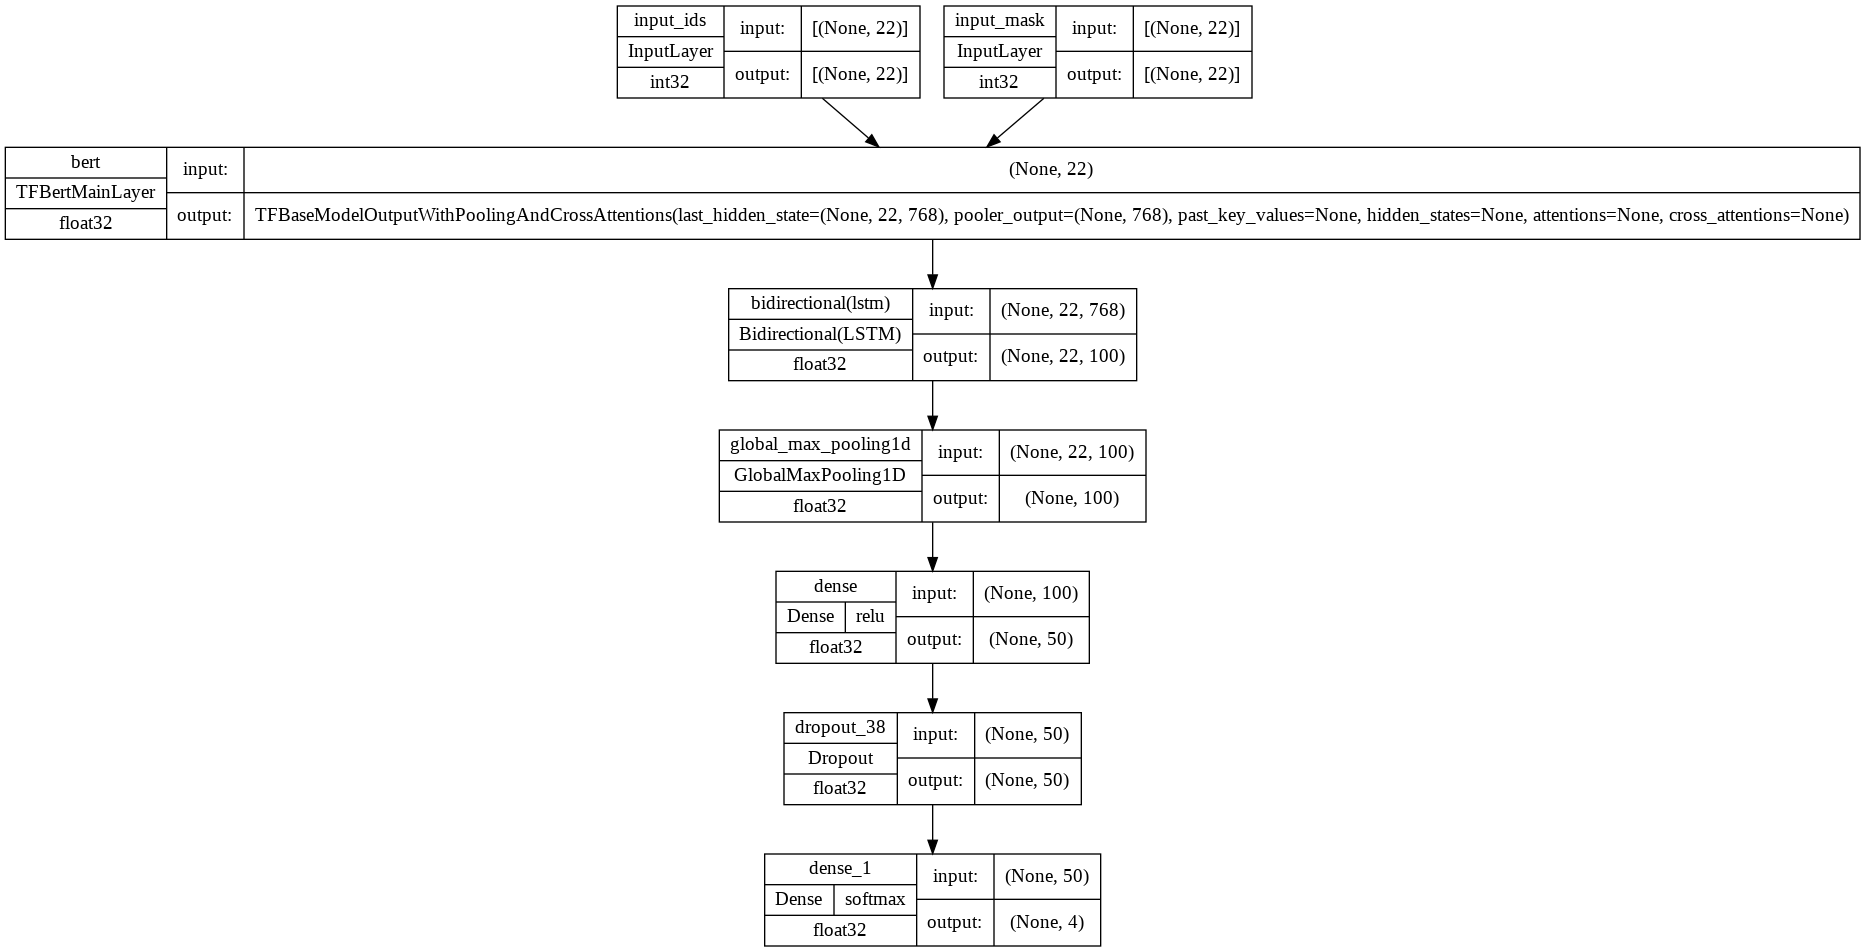

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file="/content/drive/MyDrive/bert/uncase_model.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
)

In [ ]:
history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[WandbCallback(),es]
    # callbacks=callbacks,
)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/150


/usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)
wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 68s - loss: 1.4181 - accuracy: 0.2725 - val_loss: 1.4113 - val_accuracy: 0.2525 - 68s/epoch - 1s/step
Epoch 2/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 51s - loss: 1.4319 - accuracy: 0.2325 - val_loss: 1.3845 - val_accuracy: 0.2600 - 51s/epoch - 1s/step
Epoch 3/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.4143 - accuracy: 0.2525 - val_loss: 1.3694 - val_accuracy: 0.3225 - 51s/epoch - 1s/step
Epoch 4/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.3765 - accuracy: 0.3250 - val_loss: 1.3535 - val_accuracy: 0.3325 - 51s/epoch - 1s/step
Epoch 5/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.3467 - accuracy: 0.2950 - val_loss: 1.3404 - val_accuracy: 0.3475 - 51s/epoch - 1s/step
Epoch 6/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 52s - loss: 1.3740 - accuracy: 0.2925 - val_loss: 1.3260 - val_accuracy: 0.3950 - 52s/epoch - 1s/step
Epoch 7/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.3374 - accuracy: 0.3500 - val_loss: 1.3135 - val_accuracy: 0.4025 - 51s/epoch - 1s/step
Epoch 8/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.3179 - accuracy: 0.3625 - val_loss: 1.2993 - val_accuracy: 0.4100 - 50s/epoch - 1s/step
Epoch 9/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 51s - loss: 1.3377 - accuracy: 0.3450 - val_loss: 1.2875 - val_accuracy: 0.4225 - 51s/epoch - 1s/step
Epoch 10/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.3112 - accuracy: 0.4025 - val_loss: 1.2745 - val_accuracy: 0.4375 - 51s/epoch - 1s/step
Epoch 11/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.2953 - accuracy: 0.3750 - val_loss: 1.2623 - val_accuracy: 0.4525 - 50s/epoch - 1s/step
Epoch 12/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 52s - loss: 1.2673 - accuracy: 0.4025 - val_loss: 1.2507 - val_accuracy: 0.4700 - 52s/epoch - 1s/step
Epoch 13/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 53s - loss: 1.2639 - accuracy: 0.4475 - val_loss: 1.2369 - val_accuracy: 0.4700 - 53s/epoch - 1s/step
Epoch 14/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.2503 - accuracy: 0.4475 - val_loss: 1.2256 - val_accuracy: 0.4700 - 51s/epoch - 1s/step
Epoch 15/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.2513 - accuracy: 0.4350 - val_loss: 1.2155 - val_accuracy: 0.4550 - 50s/epoch - 996ms/step
Epoch 16/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 50s - loss: 1.2471 - accuracy: 0.4200 - val_loss: 1.2097 - val_accuracy: 0.4650 - 50s/epoch - 1s/step
Epoch 17/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.2559 - accuracy: 0.4150 - val_loss: 1.2030 - val_accuracy: 0.4825 - 50s/epoch - 1s/step
Epoch 18/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 52s - loss: 1.2341 - accuracy: 0.4575 - val_loss: 1.2012 - val_accuracy: 0.5000 - 52s/epoch - 1s/step
Epoch 19/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.2264 - accuracy: 0.4325 - val_loss: 1.1950 - val_accuracy: 0.5025 - 50s/epoch - 1s/step
Epoch 20/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 51s - loss: 1.2245 - accuracy: 0.4850 - val_loss: 1.1836 - val_accuracy: 0.4900 - 51s/epoch - 1s/step
Epoch 21/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.2160 - accuracy: 0.4350 - val_loss: 1.1824 - val_accuracy: 0.4900 - 50s/epoch - 1s/step
Epoch 22/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.1978 - accuracy: 0.4300 - val_loss: 1.1716 - val_accuracy: 0.5100 - 50s/epoch - 998ms/step
Epoch 23/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.1865 - accuracy: 0.4750 - val_loss: 1.1658 - val_accuracy: 0.4900 - 51s/epoch - 1s/step
Epoch 24/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 53s - loss: 1.1754 - accuracy: 0.4775 - val_loss: 1.1625 - val_accuracy: 0.5075 - 53s/epoch - 1s/step
Epoch 25/150
50/50 - 14s - loss: 1.1936 - accuracy: 0.4950 - val_loss: 1.1635 - val_accuracy: 0.5100 - 14s/epoch - 273ms/step
Epoch 26/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 51s - loss: 1.1879 - accuracy: 0.4725 - val_loss: 1.1558 - val_accuracy: 0.5225 - 51s/epoch - 1s/step
Epoch 27/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 52s - loss: 1.1698 - accuracy: 0.4825 - val_loss: 1.1487 - val_accuracy: 0.5025 - 52s/epoch - 1s/step
Epoch 28/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.1492 - accuracy: 0.4825 - val_loss: 1.1481 - val_accuracy: 0.5275 - 50s/epoch - 1s/step
Epoch 29/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.2014 - accuracy: 0.4800 - val_loss: 1.1399 - val_accuracy: 0.5275 - 50s/epoch - 1s/step
Epoch 30/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.1470 - accuracy: 0.4775 - val_loss: 1.1356 - val_accuracy: 0.5350 - 50s/epoch - 1s/step
Epoch 31/150
50/50 - 16s - loss: 1.1749 - accuracy: 0.4725 - val_loss: 1.1364 - val_accuracy: 0.5225 - 16s/epoch - 319ms/step
Epoch 32/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.1984 - accuracy: 0.4700 - val_loss: 1.1298 - val_accuracy: 0.5225 - 50s/epoch - 1s/step
Epoch 33/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.1687 - accuracy: 0.4650 - val_loss: 1.1263 - val_accuracy: 0.5200 - 50s/epoch - 1s/step
Epoch 34/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 51s - loss: 1.1402 - accuracy: 0.5050 - val_loss: 1.1190 - val_accuracy: 0.5275 - 51s/epoch - 1s/step
Epoch 35/150
50/50 - 14s - loss: 1.1312 - accuracy: 0.5150 - val_loss: 1.1200 - val_accuracy: 0.5125 - 14s/epoch - 274ms/step
Epoch 36/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 50s - loss: 1.1343 - accuracy: 0.4900 - val_loss: 1.1169 - val_accuracy: 0.5275 - 50s/epoch - 994ms/step
Epoch 37/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 51s - loss: 1.2010 - accuracy: 0.4650 - val_loss: 1.1124 - val_accuracy: 0.5325 - 51s/epoch - 1s/step
Epoch 38/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 53s - loss: 1.1416 - accuracy: 0.5275 - val_loss: 1.1099 - val_accuracy: 0.5350 - 53s/epoch - 1s/step
Epoch 39/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 52s - loss: 1.0916 - accuracy: 0.5325 - val_loss: 1.1044 - val_accuracy: 0.5375 - 52s/epoch - 1s/step
Epoch 40/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 51s - loss: 1.1265 - accuracy: 0.5100 - val_loss: 1.1002 - val_accuracy: 0.5375 - 51s/epoch - 1s/step
Epoch 41/150
50/50 - 14s - loss: 1.1022 - accuracy: 0.5475 - val_loss: 1.1011 - val_accuracy: 0.5475 - 14s/epoch - 272ms/step
Epoch 42/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.1242 - accuracy: 0.4975 - val_loss: 1.0964 - val_accuracy: 0.5550 - 50s/epoch - 996ms/step
Epoch 43/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.1075 - accuracy: 0.5150 - val_loss: 1.0926 - val_accuracy: 0.5550 - 51s/epoch - 1s/step
Epoch 44/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 52s - loss: 1.0783 - accuracy: 0.5525 - val_loss: 1.0881 - val_accuracy: 0.5525 - 52s/epoch - 1s/step
Epoch 45/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.1374 - accuracy: 0.4825 - val_loss: 1.0857 - val_accuracy: 0.5475 - 50s/epoch - 1s/step
Epoch 46/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.0899 - accuracy: 0.5175 - val_loss: 1.0850 - val_accuracy: 0.5500 - 50s/epoch - 999ms/step
Epoch 47/150
50/50 - 13s - loss: 1.0928 - accuracy: 0.5475 - val_loss: 1.0869 - val_accuracy: 0.5450 - 13s/epoch - 265ms/step
Epoch 48/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.0691 - accuracy: 0.5650 - val_loss: 1.0805 - val_accuracy: 0.5500 - 50s/epoch - 992ms/step
Epoch 49/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.0976 - accuracy: 0.5200 - val_loss: 1.0759 - val_accuracy: 0.5600 - 50s/epoch - 996ms/step
Epoch 50/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 51s - loss: 1.0959 - accuracy: 0.5200 - val_loss: 1.0734 - val_accuracy: 0.5500 - 51s/epoch - 1s/step
Epoch 51/150
50/50 - 14s - loss: 1.0692 - accuracy: 0.5450 - val_loss: 1.0752 - val_accuracy: 0.5250 - 14s/epoch - 277ms/step
Epoch 52/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 49s - loss: 1.1054 - accuracy: 0.5050 - val_loss: 1.0702 - val_accuracy: 0.5350 - 49s/epoch - 983ms/step
Epoch 53/150
50/50 - 13s - loss: 1.1233 - accuracy: 0.5050 - val_loss: 1.0716 - val_accuracy: 0.5500 - 13s/epoch - 263ms/step
Epoch 54/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 49s - loss: 1.0607 - accuracy: 0.5775 - val_loss: 1.0678 - val_accuracy: 0.5550 - 49s/epoch - 975ms/step
Epoch 55/150
50/50 - 13s - loss: 1.1089 - accuracy: 0.5125 - val_loss: 1.0755 - val_accuracy: 0.5475 - 13s/epoch - 263ms/step
Epoch 56/150
50/50 - 13s - loss: 1.1083 - accuracy: 0.4950 - val_loss: 1.0723 - val_accuracy: 0.5425 - 13s/epoch - 252ms/step
Epoch 57/150
50/50 - 12s - loss: 1.0867 - accuracy: 0.5350 - val_loss: 1.0708 - val_accuracy: 0.5475 - 12s/epoch - 249ms/step
Epoch 58/150
50/50 - 12s - loss: 1.0700 - accuracy: 0.5200 - val_loss: 1.0687 - val_accuracy: 0.5475 - 12s/epoch - 244ms/step
Epoch 59/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 49s - loss: 1.0721 - accuracy: 0.5425 - val_loss: 1.0569 - val_accuracy: 0.5600 - 49s/epoch - 979ms/step
Epoch 60/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 49s - loss: 1.1220 - accuracy: 0.5050 - val_loss: 1.0561 - val_accuracy: 0.5525 - 49s/epoch - 988ms/step
Epoch 61/150
50/50 - 16s - loss: 1.0719 - accuracy: 0.5400 - val_loss: 1.0568 - val_accuracy: 0.5550 - 16s/epoch - 328ms/step
Epoch 62/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.0563 - accuracy: 0.5350 - val_loss: 1.0547 - val_accuracy: 0.5450 - 50s/epoch - 993ms/step
Epoch 63/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 49s - loss: 1.0560 - accuracy: 0.5700 - val_loss: 1.0543 - val_accuracy: 0.5575 - 49s/epoch - 987ms/step
Epoch 64/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.0851 - accuracy: 0.5375 - val_loss: 1.0502 - val_accuracy: 0.5475 - 50s/epoch - 1s/step
Epoch 65/150
50/50 - 13s - loss: 1.1229 - accuracy: 0.5400 - val_loss: 1.0526 - val_accuracy: 0.5525 - 13s/epoch - 260ms/step
Epoch 66/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.0217 - accuracy: 0.5800 - val_loss: 1.0468 - val_accuracy: 0.5500 - 50s/epoch - 997ms/step
Epoch 67/150
50/50 - 13s - loss: 1.0491 - accuracy: 0.5775 - val_loss: 1.0530 - val_accuracy: 0.5400 - 13s/epoch - 265ms/step
Epoch 68/150
50/50 - 13s - loss: 1.0948 - accuracy: 0.5225 - val_loss: 1.0471 - val_accuracy: 0.5475 - 13s/epoch - 259ms/step
Epoch 69/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 51s - loss: 1.1017 - accuracy: 0.4950 - val_loss: 1.0427 - val_accuracy: 0.5650 - 51s/epoch - 1s/step
Epoch 70/150
50/50 - 13s - loss: 1.0629 - accuracy: 0.5350 - val_loss: 1.0461 - val_accuracy: 0.5525 - 13s/epoch - 266ms/step
Epoch 71/150
50/50 - 13s - loss: 1.0073 - accuracy: 0.5750 - val_loss: 1.0430 - val_accuracy: 0.5500 - 13s/epoch - 254ms/step
Epoch 72/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 48s - loss: 1.0713 - accuracy: 0.5500 - val_loss: 1.0352 - val_accuracy: 0.5575 - 48s/epoch - 967ms/step
Epoch 73/150
50/50 - 13s - loss: 1.1052 - accuracy: 0.5025 - val_loss: 1.0374 - val_accuracy: 0.5575 - 13s/epoch - 268ms/step
Epoch 74/150
50/50 - 13s - loss: 1.0734 - accuracy: 0.5500 - val_loss: 1.0359 - val_accuracy: 0.5575 - 13s/epoch - 257ms/step
Epoch 75/150
50/50 - 12s - loss: 1.0585 - accuracy: 0.5325 - val_loss: 1.0380 - val_accuracy: 0.5500 - 12s/epoch - 246ms/step
Epoch 76/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 49s - loss: 1.0017 - accuracy: 0.5550 - val_loss: 1.0308 - val_accuracy: 0.5550 - 49s/epoch - 980ms/step
Epoch 77/150
50/50 - 13s - loss: 1.0371 - accuracy: 0.5675 - val_loss: 1.0383 - val_accuracy: 0.5475 - 13s/epoch - 261ms/step
Epoch 78/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 49s - loss: 1.0407 - accuracy: 0.5725 - val_loss: 1.0288 - val_accuracy: 0.5600 - 49s/epoch - 971ms/step
Epoch 79/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 52s - loss: 1.0371 - accuracy: 0.5500 - val_loss: 1.0240 - val_accuracy: 0.5550 - 52s/epoch - 1s/step
Epoch 80/150
50/50 - 13s - loss: 1.0483 - accuracy: 0.5500 - val_loss: 1.0242 - val_accuracy: 0.5650 - 13s/epoch - 257ms/step
Epoch 81/150
50/50 - 13s - loss: 1.0699 - accuracy: 0.5550 - val_loss: 1.0252 - val_accuracy: 0.5575 - 13s/epoch - 254ms/step
Epoch 82/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 49s - loss: 1.0487 - accuracy: 0.5400 - val_loss: 1.0218 - val_accuracy: 0.5625 - 49s/epoch - 970ms/step
Epoch 83/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 49s - loss: 0.9856 - accuracy: 0.5950 - val_loss: 1.0200 - val_accuracy: 0.5625 - 49s/epoch - 984ms/step
Epoch 84/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.0033 - accuracy: 0.5750 - val_loss: 1.0185 - val_accuracy: 0.5675 - 50s/epoch - 996ms/step
Epoch 85/150
50/50 - 13s - loss: 1.0331 - accuracy: 0.5600 - val_loss: 1.0191 - val_accuracy: 0.5525 - 13s/epoch - 263ms/step
Epoch 86/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 49s - loss: 1.0600 - accuracy: 0.5650 - val_loss: 1.0165 - val_accuracy: 0.5625 - 49s/epoch - 989ms/step
Epoch 87/150
50/50 - 16s - loss: 1.0079 - accuracy: 0.5700 - val_loss: 1.0177 - val_accuracy: 0.5575 - 16s/epoch - 317ms/step
Epoch 88/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 49s - loss: 1.0693 - accuracy: 0.5375 - val_loss: 1.0131 - val_accuracy: 0.5575 - 49s/epoch - 974ms/step
Epoch 89/150
50/50 - 13s - loss: 1.0941 - accuracy: 0.5425 - val_loss: 1.0253 - val_accuracy: 0.5475 - 13s/epoch - 264ms/step
Epoch 90/150
50/50 - 13s - loss: 1.0512 - accuracy: 0.5425 - val_loss: 1.0145 - val_accuracy: 0.5650 - 13s/epoch - 258ms/step
Epoch 91/150
50/50 - 12s - loss: 1.0196 - accuracy: 0.5700 - val_loss: 1.0247 - val_accuracy: 0.5625 - 12s/epoch - 247ms/step
Epoch 92/150
50/50 - 13s - loss: 1.0801 - accuracy: 0.5425 - val_loss: 1.0217 - val_accuracy: 0.5675 - 13s/epoch - 252ms/step
Epoch 93/150
50/50 - 12s - loss: 1.0526 - accuracy: 0.5300 - val_loss: 1.0168 - val_accuracy: 0.5625 - 12s/epoch - 243ms/step
Epoch 94/150
50/50 - 12s - loss: 1.0504 - accuracy: 0.5775 - val_loss: 1.0143 - val_accuracy: 0.5625 - 12s/epoch - 240ms/step
Epoch 95/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 48s - loss: 1.0574 - accuracy: 0.5325 - val_loss: 1.0089 - val_accuracy: 0.5700 - 48s/epoch - 957ms/step
Epoch 96/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.0385 - accuracy: 0.5475 - val_loss: 1.0073 - val_accuracy: 0.5650 - 50s/epoch - 1s/step
Epoch 97/150
50/50 - 13s - loss: 1.0147 - accuracy: 0.5650 - val_loss: 1.0087 - val_accuracy: 0.5675 - 13s/epoch - 267ms/step
Epoch 98/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 51s - loss: 1.0155 - accuracy: 0.5825 - val_loss: 1.0046 - val_accuracy: 0.5725 - 51s/epoch - 1s/step
Epoch 99/150
50/50 - 13s - loss: 1.0290 - accuracy: 0.5600 - val_loss: 1.0054 - val_accuracy: 0.5600 - 13s/epoch - 260ms/step
Epoch 100/150
50/50 - 13s - loss: 1.0889 - accuracy: 0.5400 - val_loss: 1.0070 - val_accuracy: 0.5650 - 13s/epoch - 259ms/step
Epoch 101/150
50/50 - 12s - loss: 0.9995 - accuracy: 0.5900 - val_loss: 1.0061 - val_accuracy: 0.5550 - 12s/epoch - 248ms/step
Epoch 102/150
50/50 - 12s - loss: 1.0010 - accuracy: 0.5675 - val_loss: 1.0076 - val_accuracy: 0.5575 - 12s/epoch - 250ms/step
Epoch 103/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 49s - loss: 1.0223 - accuracy: 0.5750 - val_loss: 1.0013 - val_accuracy: 0.5675 - 49s/epoch - 986ms/step
Epoch 104/150
50/50 - 13s - loss: 1.0376 - accuracy: 0.5525 - val_loss: 1.0076 - val_accuracy: 0.5575 - 13s/epoch - 269ms/step
Epoch 105/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.0414 - accuracy: 0.5575 - val_loss: 0.9974 - val_accuracy: 0.5750 - 50s/epoch - 992ms/step
Epoch 106/150
50/50 - 14s - loss: 0.9841 - accuracy: 0.6000 - val_loss: 1.0018 - val_accuracy: 0.5650 - 14s/epoch - 271ms/step
Epoch 107/150
50/50 - 13s - loss: 0.9930 - accuracy: 0.5975 - val_loss: 1.0015 - val_accuracy: 0.5700 - 13s/epoch - 255ms/step
Epoch 108/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.0462 - accuracy: 0.5475 - val_loss: 0.9936 - val_accuracy: 0.5700 - 51s/epoch - 1s/step
Epoch 109/150
50/50 - 13s - loss: 1.0313 - accuracy: 0.5525 - val_loss: 0.9954 - val_accuracy: 0.5700 - 13s/epoch - 261ms/step
Epoch 110/150
50/50 - 13s - loss: 1.0139 - accuracy: 0.5875 - val_loss: 0.9965 - val_accuracy: 0.5500 - 13s/epoch - 256ms/step
Epoch 111/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 49s - loss: 0.9856 - accuracy: 0.5925 - val_loss: 0.9921 - val_accuracy: 0.5725 - 49s/epoch - 971ms/step
Epoch 112/150
50/50 - 13s - loss: 0.9837 - accuracy: 0.5750 - val_loss: 0.9941 - val_accuracy: 0.5600 - 13s/epoch - 267ms/step
Epoch 113/150
50/50 - 13s - loss: 1.0147 - accuracy: 0.5725 - val_loss: 0.9922 - val_accuracy: 0.5625 - 13s/epoch - 257ms/step
Epoch 114/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.0249 - accuracy: 0.5500 - val_loss: 0.9858 - val_accuracy: 0.5725 - 50s/epoch - 992ms/step
Epoch 115/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.0251 - accuracy: 0.5375 - val_loss: 0.9836 - val_accuracy: 0.5775 - 50s/epoch - 1s/step
Epoch 116/150
50/50 - 13s - loss: 0.9967 - accuracy: 0.5800 - val_loss: 0.9870 - val_accuracy: 0.5725 - 13s/epoch - 267ms/step
Epoch 117/150
50/50 - 13s - loss: 1.0001 - accuracy: 0.5700 - val_loss: 0.9907 - val_accuracy: 0.5675 - 13s/epoch - 255ms/step
Epoch 118/150
50/50 - 15s - loss: 0.9834 - accuracy: 0.5975 - val_loss: 1.0055 - val_accuracy: 0.5550 - 15s/epoch - 305ms/step
Epoch 119/150
50/50 - 12s - loss: 0.9619 - accuracy: 0.6175 - val_loss: 0.9868 - val_accuracy: 0.5725 - 12s/epoch - 243ms/step
Epoch 120/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 49s - loss: 1.0049 - accuracy: 0.5850 - val_loss: 0.9828 - val_accuracy: 0.5725 - 49s/epoch - 977ms/step
Epoch 121/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 0.9721 - accuracy: 0.5725 - val_loss: 0.9796 - val_accuracy: 0.5775 - 50s/epoch - 996ms/step
Epoch 122/150
50/50 - 13s - loss: 1.0229 - accuracy: 0.5800 - val_loss: 0.9814 - val_accuracy: 0.5750 - 13s/epoch - 264ms/step
Epoch 123/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 49s - loss: 0.9998 - accuracy: 0.5825 - val_loss: 0.9767 - val_accuracy: 0.5825 - 49s/epoch - 977ms/step
Epoch 124/150
50/50 - 13s - loss: 1.0479 - accuracy: 0.5325 - val_loss: 0.9772 - val_accuracy: 0.5775 - 13s/epoch - 269ms/step
Epoch 125/150
50/50 - 13s - loss: 1.0408 - accuracy: 0.5600 - val_loss: 0.9824 - val_accuracy: 0.5800 - 13s/epoch - 259ms/step
Epoch 126/150
50/50 - 12s - loss: 1.0361 - accuracy: 0.5425 - val_loss: 0.9944 - val_accuracy: 0.5800 - 12s/epoch - 244ms/step
Epoch 127/150
50/50 - 12s - loss: 1.0361 - accuracy: 0.5525 - val_loss: 0.9892 - val_accuracy: 0.5750 - 12s/epoch - 241ms/step
Epoch 128/150
50/50 - 12s - loss: 0.9887 - accuracy: 0.5775 - val_loss: 0.9875 - val_accuracy: 0.5775 - 12s/epoch - 247ms/step
Epoch 129/150
50/50 - 15s - loss: 1.0202 - accuracy: 0.5775 - val_loss: 0.9858 - val_accuracy: 0.5875 - 15s/epoch - 303ms/step
Epoch 130/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 49s - loss: 1.0006 - accuracy: 0.5725 - val_loss: 0.9754 - val_accuracy: 0.5775 - 49s/epoch - 971ms/step
Epoch 131/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.6s


50/50 - 50s - loss: 1.0213 - accuracy: 0.5575 - val_loss: 0.9743 - val_accuracy: 0.5900 - 50s/epoch - 1s/step
Epoch 132/150
50/50 - 13s - loss: 0.9873 - accuracy: 0.5600 - val_loss: 0.9952 - val_accuracy: 0.5575 - 13s/epoch - 263ms/step
Epoch 133/150
50/50 - 13s - loss: 0.9700 - accuracy: 0.5650 - val_loss: 0.9777 - val_accuracy: 0.5875 - 13s/epoch - 251ms/step
Epoch 134/150
50/50 - 12s - loss: 1.0000 - accuracy: 0.5825 - val_loss: 0.9764 - val_accuracy: 0.5875 - 12s/epoch - 240ms/step
Epoch 135/150
50/50 - 12s - loss: 0.9775 - accuracy: 0.5975 - val_loss: 0.9777 - val_accuracy: 0.5950 - 12s/epoch - 243ms/step
Epoch 136/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.8s


50/50 - 48s - loss: 1.0459 - accuracy: 0.5400 - val_loss: 0.9743 - val_accuracy: 0.5875 - 48s/epoch - 965ms/step
Epoch 137/150
50/50 - 13s - loss: 0.9308 - accuracy: 0.6050 - val_loss: 0.9748 - val_accuracy: 0.5850 - 13s/epoch - 260ms/step
Epoch 138/150
50/50 - 13s - loss: 0.9887 - accuracy: 0.5950 - val_loss: 0.9812 - val_accuracy: 0.5650 - 13s/epoch - 253ms/step
Epoch 139/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 50s - loss: 1.0115 - accuracy: 0.5775 - val_loss: 0.9727 - val_accuracy: 0.5800 - 50s/epoch - 1s/step
Epoch 140/150
50/50 - 13s - loss: 1.0141 - accuracy: 0.5725 - val_loss: 0.9767 - val_accuracy: 0.5800 - 13s/epoch - 263ms/step
Epoch 141/150
50/50 - 13s - loss: 1.0055 - accuracy: 0.5825 - val_loss: 0.9765 - val_accuracy: 0.5675 - 13s/epoch - 256ms/step
Epoch 142/150
50/50 - 12s - loss: 0.9424 - accuracy: 0.6225 - val_loss: 0.9768 - val_accuracy: 0.5725 - 12s/epoch - 243ms/step
Epoch 143/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 48s - loss: 0.9362 - accuracy: 0.6325 - val_loss: 0.9718 - val_accuracy: 0.5800 - 48s/epoch - 959ms/step
Epoch 144/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 51s - loss: 1.0836 - accuracy: 0.5175 - val_loss: 0.9688 - val_accuracy: 0.5875 - 51s/epoch - 1s/step
Epoch 145/150
50/50 - 13s - loss: 0.9767 - accuracy: 0.6100 - val_loss: 0.9709 - val_accuracy: 0.5825 - 13s/epoch - 268ms/step
Epoch 146/150
50/50 - 13s - loss: 1.0094 - accuracy: 0.5750 - val_loss: 0.9737 - val_accuracy: 0.5850 - 13s/epoch - 256ms/step
Epoch 147/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 48s - loss: 0.9088 - accuracy: 0.6200 - val_loss: 0.9632 - val_accuracy: 0.5850 - 48s/epoch - 964ms/step
Epoch 148/150
50/50 - 16s - loss: 0.9845 - accuracy: 0.5775 - val_loss: 0.9682 - val_accuracy: 0.5800 - 16s/epoch - 319ms/step
Epoch 149/150


wandb: Adding directory to artifact (/content/wandb/run-20221206_163110-in3bjz1i/files/model-best)... Done. 2.7s


50/50 - 49s - loss: 0.9850 - accuracy: 0.6100 - val_loss: 0.9602 - val_accuracy: 0.5800 - 49s/epoch - 989ms/step
Epoch 150/150
50/50 - 13s - loss: 1.0305 - accuracy: 0.5600 - val_loss: 0.9646 - val_accuracy: 0.5925 - 13s/epoch - 259ms/step


In [ ]:
ls /content

 bert/          test.csv                    'Untitled Folder'/
 sample_data/   twitter_sentiment_data.csv


In [ ]:
model.save("/content/drive/MyDrive/bert/model")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

CLASSES = [-1,0,1,2]

# config = RobertaTokenizer.from_pretrained("roberta-base",
                                             #     num_labels=len(CLASSES),
                                             #  id2label={0:-1,1:0,2:1,3:2},
                                             # label2id={-1:0,0:1,1:2,2:3},
                                             #     )

tokenizer = BertTokenizer.from_pretrained(model_id)

In [ ]:
def predict(text, model, max_seq_length):
    tokenizer = BertTokenizer.from_pretrained(model_id)
    
     # config = RobertaTokenizer.from_pretrained("roberta-base",
     #                                             num_labels=len(CLASSES),
     #                                          id2label={0:-1,1:0,2:1,3:2},
     #                                         label2id={-1:0,0:1,1:2,2:3},
     #                                             )
    id2label={0:-1,1:0,2:1,3:2}
    encode_plus_tokens = tokenizer.encode_plus(
        text, 
        padding='max_length', 
        max_length=max_seq_length, 
        truncation=True, 
        return_tensors="tf"
    )
    # The id from the pre-trained BERT vocabulary that represents the token.  (Padding of 0 will be used if the # of tokens is less than `max_seq_length`)
    input_ids = encode_plus_tokens["input_ids"]

    # Specifies which tokens BERT should pay attention to (0 or 1).  Padded `input_ids` will have 0 in each of these vector elements.
    input_mask = encode_plus_tokens["attention_mask"]

    outputs = model.predict(x=(input_ids, input_mask))

    prediction = [{"label": id2label[item.argmax()], "score": item.max().item()} for item in outputs]

    return prediction[0]["label"]

In [ ]:
# from tensorflow import keras
# model = keras.models.load_model('/content/drive/MyDrive/bert/model')

y_test = [predict(message, model, max_seq_length) for message in df_test["message"][:50]]
y_test

y_actual = df_test["sentiment"][:50]
y_actual


1/1 [==============================] - 0s 55ms/step


0    -1
1     0
2    -1
3    -1
4     1
5     2
6     0
7     2
8     1
9     2
10    0
11   -1
12    0
13    2
14   -1
15    0
16   -1
17    2
18    2
19    0
20    2
21   -1
22    2
23    1
24   -1
25    0
26    1
27    0
28    1
29    0
30   -1
31    2
32    1
33    2
34   -1
35    1
36    1
37    1
38    0
39    2
40   -1
41   -1
42    1
43    1
44   -1
45    2
46    1
47    2
48   -1
49    0
Name: sentiment, dtype: int64

In [ ]:
valpr=set(y_test)

In [ ]:
valpr

{-1, 0, 1, 2}

In [ ]:
valtr=set(y_actual)

In [ ]:
valtr

{-1, 0, 1, 2}

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [ ]:
classification_report(y_true=y_test, y_pred=y_actual)

'              precision    recall  f1-score   support\n\n          -1       0.79      0.73      0.76        15\n           0       0.45      0.50      0.48        10\n           1       0.83      0.77      0.80        13\n           2       0.62      0.67      0.64        12\n\n    accuracy                           0.68        50\n   macro avg       0.67      0.67      0.67        50\nweighted avg       0.69      0.68      0.68        50\n'

In [ ]:
accuracy = accuracy_score(y_true=y_test, y_pred=y_actual)
print("Test accuracy: ", accuracy)

Test accuracy:  0.68


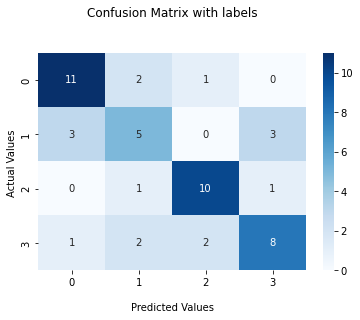

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(y_actual, y_test)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
# ax.xaxis.set_ticklabels(['False','True'])
# ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:

pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 43.9 MB/s 


In [ ]:
import keras_tuner as kt

In [ ]:
def build_model(hp):
  transformer_model = TFAutoModelForSequenceClassification.from_pretrained(model_id, config=config)
  input_ids = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype="int32")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_mask", dtype="int32")
  embedding_layer = transformer_model.bert(input_ids, attention_mask=input_mask)[0]
  X = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True, dropout=0.1, recurrent_dropout=0.1))(
    embedding_layer
   )
  X = tf.keras.layers.GlobalMaxPool1D()(X)
  X = tf.keras.layers.Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation="relu")(X)
  X = tf.keras.layers.Dropout(0.2)(X)
  X = tf.keras.layers.Dense(len(CLASSES), activation="softmax")(X)

  model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=X)
  freeze_bert_layer=hp.Choice('freezelayer', values=[True,False])
  for layer in model.layers[:hp.Choice('num_freeze_layers', values=[0, 2, 3])]:
    layer.trainable = not freeze_bert_layer
  loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

  metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")
  learning_rate=hp.Choice("learning_rate",values=[3e-5,(3e-5)*100,(3e-5)/100])
  optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon)

  model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

  model.summary()
  return model

In [ ]:
import kerastuner as kt
from kerastuner.tuners import RandomSearch, Hyperband, BayesianOptimization
from wandb.keras import WandbCallback

class MyTuner(kt.Tuner):

    def run_trial(self,trial, train_dataset,validation_dataset, steps_per_epoch, epochs, objective):
      
        hp = trial.hyperparameters
        objective_name_str = objective

        ## create the model with the current trial hyperparameters
        model = self.hypermodel.build(hp)
        
        ## Initiates new run for each trial on the dashboard of Weights & Biases
        run = wandb.init(project="hyperparam-test", entity="ariq913", config=hp.values)

        ## WandbCallback() logs all the metric data such as
        ## loss, accuracy and etc on dashboard for visualization
        history = model.fit(
    train_dataset,
    shuffle=True,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_dataset,
    validation_steps=validation_steps,
    verbose=2,
    callbacks=[WandbCallback()]
    # callbacks=callbacks,
            )
        # history = model.fit(trainX,
        #           trainY,
        #           batch_size=batch_size,
        #           epochs=epochs,
        #           validation_split=0.1,
        #           callbacks=[WandbCallback()])  

        ## if val_accurcy used, use the val_accuracy of last epoch model which is fully trained
        val_acc = history.history['val_accuracy'][-1]  ## [-1] will give the last value in the list

        ## Send the objective data to the oracle for comparison of hyperparameters
        self.oracle.update_trial(trial.trial_id, {objective_name_str:val_acc})

        ## save the trial model
        # self.save_model(trial.trial_id, model)
        
        ## ends the run on the Weights & Biases dashboard
        run.finish()

In [ ]:
## set the objective of tuning algorithm
objective = 'val_accuracy'
  
## instantiate the new Tuner with tuning algorithm and required parameters
tuner = MyTuner(
      oracle=kt.oracles.RandomSearch(
          objective=objective,
          max_trials=4),
      hypermodel=build_model,
      directory='/content/drive/MyDrive/hyperparam/')

tuner.search_space_summary()

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 18)]         0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 18)]         0           []                               
                                                                                                  
 roberta (TFRobertaMainLayer)   TFBaseModelOutputWi  124055040   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'input_mask[0][0]']             
                                tentions(last_hidde                                               
                                n_state=(None, 18,                                          

In [ ]:
tuner.search(train_dataset, validation_dataset, steps_per_epoch=steps_per_epoch, epochs=2, objective=objective)



Trial 4 Complete [00h 02m 39s]
val_accuracy: 0.27250000834465027

Best val_accuracy So Far: 0.4362500011920929
Total elapsed time: 00h 13m 46s


In [ ]:
best_hps = tuner.get_best_hyperparameters()[0]
print(best_hps.values)

## get the best
best_model = tuner.get_best_models()[0]